In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Aquisição de Dados

In [2]:
df = yf.download(['BPAC3.SA', 'PETR4.SA', 'OIBR3.SA', 'ITUB4.SA', 'BBDC4.SA'])['Close']

[*********************100%***********************]  5 of 5 completed


In [3]:
df.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
Date,,,,,
2000-01-03,NaN,NaN,NaN,NaN,5.875
2000-01-04,NaN,NaN,NaN,NaN,5.550
2000-01-05,NaN,NaN,NaN,NaN,5.494
2000-01-06,NaN,NaN,NaN,NaN,5.475
2000-01-07,NaN,NaN,NaN,NaN,5.500


In [4]:
retornos = df.pct_change().loc['2018-01-01':]

In [5]:
retornos.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
Date,,,,,
2018-01-02,0.022157,0.091245,0.030528,-0.008265,0.027950
2018-01-03,0.004048,0.000000,0.006837,-0.027778,0.009064
2018-01-04,0.016407,0.000000,0.020826,-0.005712,0.001796
2018-01-05,0.005664,-0.028249,0.002880,0.005745,0.005977
2018-01-08,-0.000283,0.000000,-0.003316,-0.011428,0.011884


## Clusterização

### Normalização dos dados

In [6]:
from sklearn.preprocessing import normalize

retornos_normalizados = normalize(retornos)
retornos_normalizados = pd.DataFrame(retornos_normalizados, columns=retornos.columns)

retornos_normalizados.head()

,BBDC4.SA,BPAC3.SA,ITUB4.SA,OIBR3.SA,PETR4.SA
0,0.215229,0.886330,0.296543,-0.080282,0.271500
1,0.133676,0.000000,0.225786,-0.917365,0.299321
2,0.603632,0.000000,0.766222,-0.210154,0.066089
3,0.188047,-0.937934,0.095632,0.190746,0.198464
4,-0.016798,0.000000,-0.197172,-0.679446,0.706537


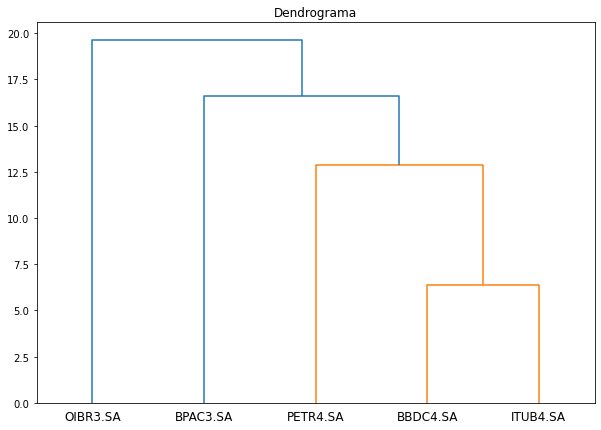

In [7]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")

clusters = shc.linkage(retornos_normalizados.T, method='ward', metric='euclidean')

dend = shc.dendrogram(clusters, labels=retornos.columns)

### Reodernando dataframe de retornos

In [17]:
retornos.iloc[:,dend['leaves']]

,OIBR3.SA,BPAC3.SA,PETR4.SA,BBDC4.SA,ITUB4.SA
Date,,,,,
2018-01-02,-0.008265,0.091245,0.027950,0.022157,0.030528
2018-01-03,-0.027778,0.000000,0.009064,0.004048,0.006837
2018-01-04,-0.005712,0.000000,0.001796,0.016407,0.020826
2018-01-05,0.005745,-0.028249,0.005977,0.005664,0.002880
2018-01-08,-0.011428,0.000000,0.011884,-0.000283,-0.003316
...,...,...,...,...,...
2020-09-14,0.134969,-0.010552,-0.009141,0.011730,0.017774
2020-09-15,-0.021622,-0.024661,-0.000461,-0.010628,-0.013306
2020-09-16,0.005525,-0.006834,0.002769,0.001953,-0.002950


## Matrix Seriation

<AxesSubplot:>

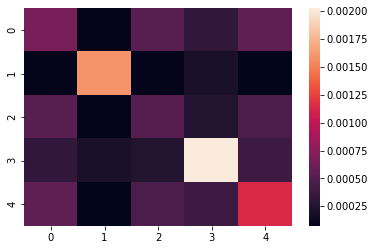

In [8]:
sns.heatmap(np.cov(retornos.T))

<AxesSubplot:>

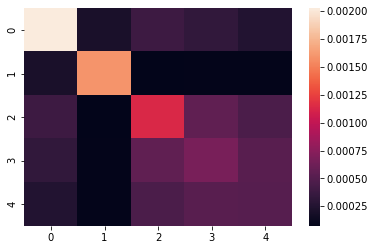

In [16]:
sns.heatmap(np.cov(retornos.iloc[:,dend['leaves']].T))

In [32]:
def compute_HRP_weights(covariances, res_order):
    # Inicialização de pesos
    pesos = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        # Instanciação de clusters do laço
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        print(clustered_alphas)

        # Iteração entre pares semelhantes
        for subcluster in range(0, len(clustered_alphas), 2):
            # Separação de galhos da árvore
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]
            
            # Calcula da matriz de covarinças do primeiro cluster
            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            # Calcula da matriz de covarinças do segundo cluster
            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            # Fator de alocação inter cluster
            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            # Normalização dos clusters esquerdo e direito
            pesos[left_cluster] *= alloc_factor
            pesos[right_cluster] *= 1 - alloc_factor
            
    return pesos

In [33]:
compute_HRP_weights(retornos.cov(), retornos.columns[dend['leaves']])

[Index(['OIBR3.SA', 'BPAC3.SA'], dtype='object'), Index(['PETR4.SA', 'BBDC4.SA', 'ITUB4.SA'], dtype='object')]
[Index(['OIBR3.SA'], dtype='object'), Index(['BPAC3.SA'], dtype='object'), Index(['PETR4.SA'], dtype='object'), Index(['BBDC4.SA', 'ITUB4.SA'], dtype='object')]
[Index(['BBDC4.SA'], dtype='object'), Index(['ITUB4.SA'], dtype='object')]
[]


OIBR3.SA    0.158242
BPAC3.SA    0.200618
PETR4.SA    0.207976
BBDC4.SA    0.186682
ITUB4.SA    0.246482
dtype: float64